In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
import torchcde
from tqdm.notebook import tqdm
from scipy.signal import find_peaks
import MulensModel as mm
import corner
from model.utils import inference, get_loglik, get_peak_pred, plot_params, simulate_lc, infer_lgfs
from matplotlib.offsetbox import AnchoredText

torch.random.manual_seed(42)
np.random.seed(42)
plt.rcParams["font.family"] = "serif"
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'

In [2]:
with h5py.File('/work/hmzhao/irregular-lc/KMT-loc-test.h5', mode='r') as dataset_file:
    Y = torch.tensor(dataset_file['Y'][...])
    X = torch.tensor(dataset_file['X'][...])
# preprocess
nanind = torch.where(~torch.isnan(X[:, 0, 1]))[0]
# Y: t_0, t_E, u_0, rho, q, s, alpha, f_s

Y = Y[nanind]
X = X[nanind]
X = X[:, :, :2]

In [3]:
from model.locator import Locator
import torchcde
import os

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

checkpt = torch.load('/work/hmzhao/experiments/locator/experiment_54125.ckpt', map_location='cpu')
ckpt_args = checkpt['args']
state_dict = checkpt['state_dict']

train_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(X)

model = Locator(device).to(device)
model_dict = model.state_dict()

# 1. filter out unnecessary keys
state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(state_dict) 
# 3. load the new state dict
model.load_state_dict(state_dict)
model.to(device)

Locator(
  (prefilter): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=reflect)
    (1): PReLU(num_parameters=1)
    (2): Conv1d(16, 16, kernel_size=(15,), stride=(1,), padding=(7,), padding_mode=reflect)
    (3): PReLU(num_parameters=1)
    (4): Conv1d(16, 1, kernel_size=(1,), stride=(1,), padding_mode=reflect)
    (5): PReLU(num_parameters=1)
  )
  (unet): UNET_1D(
    (AvgPool1D1): AvgPool1d(kernel_size=(1,), stride=(5,), padding=(0,))
    (AvgPool1D2): AvgPool1d(kernel_size=(1,), stride=(25,), padding=(0,))
    (AvgPool1D3): AvgPool1d(kernel_size=(1,), stride=(125,), padding=(0,))
    (layer1): Sequential(
      (0): conbr_block(
        (conv1): Conv1d(1, 128, kernel_size=(7,), stride=(1,), padding=(3,))
        (bn): InstanceNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (relu): PReLU(num_parameters=1)
      )
      (1): re_block(
        (cbr1): conbr_block(
          (conv1): Conv1d(128, 128, k

In [4]:
size = 4096 * 4
batchsize = 128
pred = torch.zeros((size, 2))
z = torch.zeros((batchsize, 2)).to(device)
model.eval()
model.plot = False
model.soft_threshold = True
model.threshold = 0.5
with torch.no_grad():
    for i in tqdm(range(size // batchsize)):
        batch = train_coeffs[i*batchsize:i*batchsize+batchsize].float().to(device)
        pred[i*batchsize:i*batchsize+batchsize] = model(batch, z)[0].detach().cpu()

  0%|          | 0/128 [00:00<?, ?it/s]

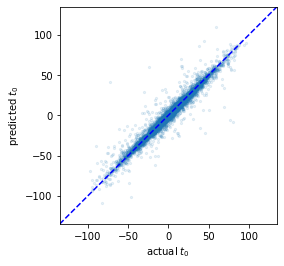

tensor([  6.4454, -11.7793, -10.9590, -16.2323,  28.0633, -13.8165,  -4.3302,
         -4.4253,  68.3217,  11.1644], dtype=torch.float64)
[  6.612842   -7.5739083 -12.863479  -19.69869    25.243946  -13.762339
  -4.4894166  -3.7944207  66.036      12.136084 ]
rmse of t_0  4.1469066063717515


In [5]:
plt.axis('square')
plt.xlim(-135, 135)
plt.ylim(-135, 135)
plt.xlabel(r'actual $t_0$')
plt.ylabel(r'predicted $t_0$')
plt.scatter(Y[:size, 0], pred.numpy()[:size, 0], s=5, alpha=0.1)
plt.plot(np.linspace(-135, 135), np.linspace(-135, 135), color='b', linestyle='dashed')
plt.show()
print(Y[:10, 0])
print(pred.numpy()[:10, 0])
print('rmse of t_0 ', torch.sqrt(torch.mean((Y[:size, 0] -  pred.numpy()[:size, 0])**2, dim=0)).detach().cpu().item())
# print('mse of t_0 ', torch.mean((Y[:num, 0] -  pred_rand.numpy()[:num, 0])**2, dim=0).detach().cpu().item())

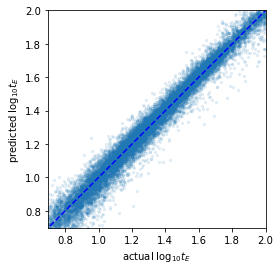

tensor([15.2177, 33.2011, 20.7851, 30.0660, 30.7152, 31.0744, 27.8128,  6.1498,
        74.5315, 25.3372], dtype=torch.float64)
[15.362192  32.504505  22.829124  30.139877  31.499456  34.473312
 27.147366   5.3021507 80.93313   24.682999 ]
rmse of lgt_E:  0.05885165520907988


In [6]:
plt.axis('square')
plt.xlim(np.log10(5), 2)
plt.ylim(np.log10(5), 2)
plt.xlabel(r'actual $\log_{10}t_E$')
plt.ylabel(r'predicted $\log_{10}t_E$')
plt.scatter(np.log10(Y[:size, 1]), np.log10(pred.numpy()[:size, 1]), s=5, alpha=0.1)
plt.plot(np.linspace(0, 2), np.linspace(0, 2), color='b', linestyle='dashed')
plt.show()
print(Y[:10, 1])
print(pred.numpy()[:10, 1])
print('rmse of lgt_E: ', torch.sqrt((torch.mean((np.log10(Y[:size, 1]) -  np.log10(pred.numpy()[:size, 1]))**2, dim=0))).detach().cpu().item())
# print('mse of rand t_E: ', torch.mean((Y[:num, 1] -  pred_rand.numpy()[:num, 1])**2, dim=0).detach().cpu().item())

In [13]:
# transform
X_loc = X[:size].clone()
Y_loc = Y[:size].clone()
X_loc[:, :, 0] = (X_loc[:, :, 0] - pred[:, [0]]) / pred[:, [1]]
X_loc[:, :, 1] = (X_loc[:, :, 1] - 14.5 - 2.5 * torch.log10(Y_loc[:, [-1]])) / 0.2

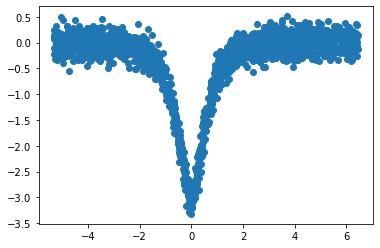

In [14]:
plt.scatter(X_loc[2, :, 0], X_loc[2, :, 1])

In [15]:
max_len = 0
lc_list = []
for i in tqdm(range(size)):
    # try:
    lc = X_loc[i]
    lc = lc[torch.where((lc[:, 0] <= 2) * (lc[:, 0] >= -2))]
    depth = 3; window_length = max(len(lc)//100, 1)
    lc = torchcde.logsig_windows(lc, depth, window_length=window_length)
    max_len = max(max_len, len(lc))
    lc = torch.cat([lc, lc[-1].expand(X_loc.shape[1] - len(lc), lc.shape[-1])])
    lc_list.append(lc)
    # except:
    #     print(X_loc[i, :, 0])
    #     plt.plot(X_loc[i, :, 0], X_loc[i, :, 1])
    #     plt.show()

X_loc = torch.stack(lc_list, dim=0)[:, :max_len]
Y_loc = Y[:size]

  0%|          | 0/16384 [00:00<?, ?it/s]

In [17]:
np.save('/work/hmzhao/X_loc.npy', X_loc)
np.save('/work/hmzhao/Y_loc.npy', Y_loc)

In [18]:
X = X_loc
Y = Y_loc
Y[:, 3:6] = torch.log10(Y[:, 3:6])
Y[:, -1] = torch.log10(Y[:, -1])
Y[:, 6] = Y[:, 6] / 180
Y = Y[:, [2, 4, 5, 6, 7]]
print('Shape of Y: ', Y.shape)

print(f'normalized X mean: {torch.mean(X[:, :, 1])}\nX std: {torch.mean(torch.std(X[:, :, 1], axis=0))}')
coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(X)

Shape of Y:  torch.Size([16384, 5])
normalized X mean: -0.755313764496367
X std: 0.8830238933386503


In [19]:
from model.cde_mdn import CDE_MDN

device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")

checkpt = torch.load('/work/hmzhao/experiments/cde_mdn/experiment_l32nG12diag.ckpt', map_location='cpu')
ckpt_args = checkpt['args']
state_dict = checkpt['state_dict']

output_dim = Y.shape[-1]
input_dim = X.shape[-1]
latent_dim = ckpt_args.latents

model = CDE_MDN(input_dim, latent_dim, output_dim).to(device)
# model = CDE_MDN(input_dim, latent_dim, output_dim, 32).to(device)
model_dict = model.state_dict()

# 1. filter out unnecessary keys
state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(state_dict) 
# 3. load the new state dict
model.load_state_dict(state_dict)
model.to(device)

CDE_MDN(
  (cde_func): CDEFunc(
    (linear1): Linear(in_features=32, out_features=1024, bias=True)
    (relu1): PReLU(num_parameters=1)
    (resblocks): Sequential(
      (0): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (1): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (2): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
    )
    (relu2): PReLU(num_parameters=1)
    (linear2): Linear(in_features=1024, out_features=160, bias=True)
    (tanh): Tanh()
    (linear3): Linear(in_features=

In [20]:
pis, locs, scales = inference(model, size, min(4096, size), coeffs, device, full_cov=False)

  0%|          | 0/4 [00:00<?, ?it/s]

In [21]:
pred_global, pred_global_loglik, pred_close, pred_close_loglik = get_peak_pred(pis, locs, scales, Y, n_step=1000)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

In [22]:
print(pred_global_loglik.sum(dim=1).mean(), pred_close_loglik.sum(dim=1).mean())

tensor(10.6443) tensor(6.9475)


mse of log10q global:  0.20363340022191992
mse of log10q close:  0.10794172540201527
constraint 0.989990234375
correct 0.7737977805178792
mse of log10s global:  0.053495600912572557
mse of log10s close:  0.006221783563897446
constraint 0.98980712890625
correct 0.6623913177529753
mse of u0:  0.027824915658949127
mse of u0:  0.011642597630775929
constraint 0.98931884765625
correct 0.7717317539638473
mse of alpha global:  11891.723357820787
mse of alpha close:  457.5196109090613
constraint 0.98931884765625
correct 0.5519156024430871
mse of log10fs global:  0.01361558625635684
mse of log10fs close:  0.009665452348612578


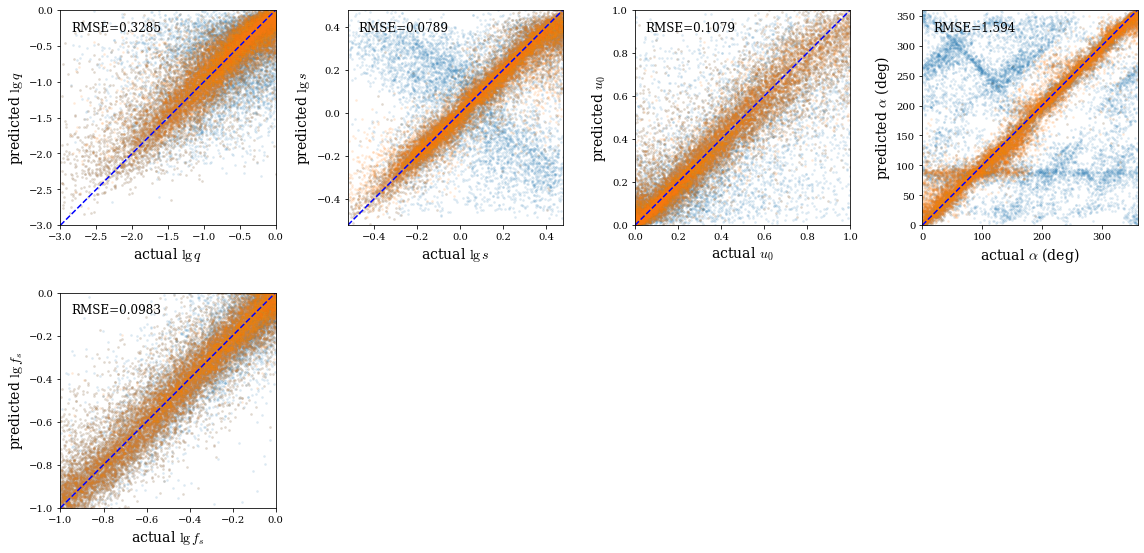

In [23]:
rmse = plot_params(size, Y, pred_global, pred_global_loglik, pred_close, pred_close_loglik, title=None)